In [1]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
size = 256
batch_size = 128
epochs = 20
history = {}
def build_model(initializer, optimizer):
    input_shape = (size, size, 3)
    hidden_layer_1 = 1024
    hidden_layer_2 = 512
    num_classes = 39
    layers = [
        Flatten(input_shape=input_shape),
        Dense(hidden_layer_1, activation='relu', kernel_initializer=initializer),
        Dense(hidden_layer_2, activation='relu', kernel_initializer=initializer),
        Dense(num_classes, activation='softmax', kernel_initializer=initializer)
    ]
    model = tf.keras.Sequential(layers)
    model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
    )
    return model

In [3]:
optim = {}
sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
optim['sgd'] = sgd
sgd_momentum = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
optim['sgd_momentum'] = sgd_momentum
rmsprop = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07)
optim['rmsprop'] = rmsprop
adam = tf.keras.optimizers.Adam()
optim['adam'] = adam
initializer = tf.keras.initializers.GlorotNormal()

In [4]:
path = '../input/official-leaf/train_aug'
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_gen.flow_from_directory(path,     
    target_size = (size, size),
    shuffle=True, 
    batch_size=batch_size,
    subset='training',
)
valid_generator = train_gen.flow_from_directory(path,     
    target_size = (size, size),
    shuffle=False, 
    batch_size=batch_size,
    subset='validation',
)

Found 42536 images belonging to 39 classes.
Found 10628 images belonging to 39 classes.


In [5]:
def train_model(k, v):
    model = build_model(initializer, v)
    model.summary()
    print('This is a model using:', k)
    print()
    model_save = ModelCheckpoint('./ANN_official_' + k + '.h5',
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = 'val_loss', 
                                 mode = 'min', verbose = 1)
    if k != 'sgd_momentum':
        reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, 
                                      patience = 2, min_delta = 0.001, 
                                      mode = 'min', verbose = 1)
        print(k + ' using ReduceLROnPlateau')
        print()
        milestones = model.fit(train_generator,
              validation_data=valid_generator,
              epochs=epochs,
              steps_per_epoch=train_generator.n//train_generator.batch_size,
              validation_steps = valid_generator.n//valid_generator.batch_size,
              callbacks = [model_save, early_stop, reduce_lr]
              )
    else:
        print(k + ' not using ReduceLROnPlateau')
        print()
        milestones = model.fit(train_generator,
              validation_data=valid_generator,
              epochs=epochs,
              steps_per_epoch=train_generator.n//train_generator.batch_size,
              validation_steps = valid_generator.n//valid_generator.batch_size,
              callbacks = [model_save, early_stop]
              )
    history[k] = milestones

In [6]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                               patience = 5, mode = 'min', verbose = 1,
                               restore_best_weights = True)
for k, v in optim.items():
    train_model(k, v)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              201327616 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 39)                20007     
Total params: 201,872,423
Trainable params: 201,872,423
Non-trainable params: 0
_________________________________________________________________
This is a model using: sgd

sgd using ReduceLROnPlateau

Epoch 1/20
332/332 [==============================] - 433s 1s/step - loss: 4.0663 - accuracy: 0.1507 - val_loss: 2.4216 - val_accuracy: 0.3262

Epoch 00001: val_loss improved from inf

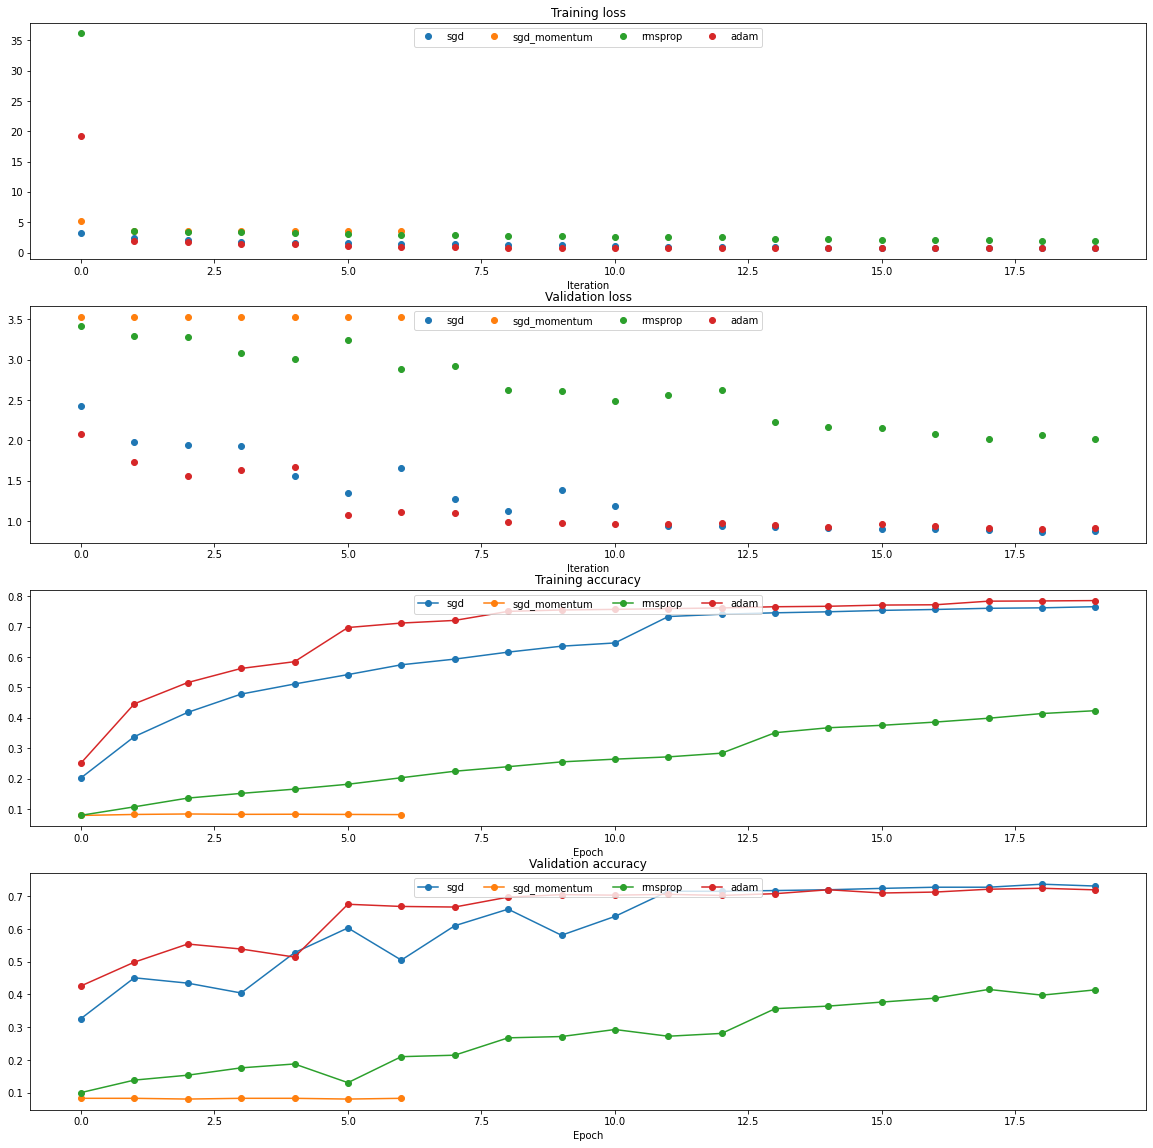

In [7]:
#Drawing
plt.subplot(4, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(4, 1, 2)
plt.title('Validation loss')
plt.xlabel('Iteration')

plt.subplot(4, 1, 3)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(4, 1, 4)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, milestone in history.items():
    plt.subplot(4, 1, 1)
    plt.plot(milestone.history['loss'], 'o', label=update_rule)

    plt.subplot(4, 1, 2)
    plt.plot(milestone.history['val_loss'], 'o', label=update_rule)

    plt.subplot(4, 1, 3)
    plt.plot(milestone.history['accuracy'], '-o', label=update_rule)
    
    plt.subplot(4, 1, 4)
    plt.plot(milestone.history['val_accuracy'], '-o', label=update_rule)

for i in [1, 2, 3, 4]:
    plt.subplot(4, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(20, 20)
plt.show()